# Uczenie Maszynowe (laboratorium 5)

Bartosz Klimza

# Zaimportowanie bibliotek

In [92]:
from sklearn.datasets import load_iris, load_wine, load_boston 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, ClassifierMixin
import seaborn as sns
import random
from math import sqrt
import numpy as np
from numpy.linalg import inv
from matplotlib import pyplot as plt
import scipy.stats as stats

# Załadowanie zbiorów

In [3]:
X_iris, y_iris = load_iris(return_X_y=True)
X_wine, y_wine = load_wine(return_X_y=True)
X_boston, y_boston = load_boston(return_X_y=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

# Gaussowski Naiwny Klasyfikator Bayesa

In [23]:
class GNB(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.priors = np.bincount(y) / len(y)
        self.classes = np.max(y) + 1
        self.means = np.array([X[np.where(y==i)].mean(axis=0) for i in range(self.classes)])
        self.stds = np.array([X[np.where(y==i)].std(axis=0) for i in range(self.classes)])
        return self
    
    def predict_prob(self, X):
        result_list = []
        for i in range(len(X)):
            probas = []
            for j in range(self.classes):
                probas.append((1/np.sqrt(2*np.pi*self.stds[j]**2)*np.exp(-0.5*((X[i]-self.means[j])/self.stds[j])**2)).prod()*self.priors[j])
            probas = np.array(probas)
            result_list.append(probas / probas.sum())
        return np.array(result_list)
    
    def predict(self, X):
        result_list = self.predict_prob(X)
        return result_list.argmax(axis=1)

## Test dla zbioru danych Iris

In [47]:
error = 0
error_list = []
for _ in range(20):
    gnb = GNB()
    X_train, x_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=random.choice([0.4, 0.6]))
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(x_test)
    error += 1 - accuracy_score(y_test, y_pred)
    error_list.append(1 - accuracy_score(y_test, y_pred))
mean_error = error / 20
stdev = sqrt(sum([(i - mean_error) ** 2 for i in error_list]) / (len(error_list) - 1))
print("Mean error:", mean_error)
print("Std dev:", stdev)
    

Mean error: 0.050555555555555555
Std dev: 0.01718492471403063


## Test dla zbioru danych Wine

Standardowe skalowanie

In [83]:
X_standard = StandardScaler().fit_transform(X_wine)
accuracy = 0
for _ in range(20):
    gnb = GNB()
    X_train, x_test, y_train, y_test = train_test_split(X_standard, y_wine, test_size=0.3)
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(x_test)
    accuracy += accuracy_score(y_test, y_pred)
mean_accuracy = accuracy / 20
print("Mean accuracy:", mean_accuracy)

Mean accuracy: 0.9666666666666666


PCA

In [74]:
X_PCA = PCA(n_components=2).fit_transform(X_wine)
accuracy = 0
for _ in range(20):
    gnb = GNB()
    X_train, x_test, y_train, y_test = train_test_split(X_PCA, y_wine, test_size=0.3)
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(x_test)
    accuracy += accuracy_score(y_test, y_pred)
mean_accuracy = accuracy / 20
print("Mean accuracy:", mean_accuracy)

Mean accuracy: 0.7333333333333333


Standardowe skalowanie + PCA

In [79]:
X_PCA = PCA(n_components=2).fit_transform(X_standard)
accuracy = 0
for _ in range(20):
    gnb = GNB()
    X_train, x_test, y_train, y_test = train_test_split(X_PCA, y_wine, test_size=0.3)
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(x_test)
    accuracy += accuracy_score(y_test, y_pred)
mean_accuracy = accuracy / 20
print("Mean accuracy:", mean_accuracy)

Mean accuracy: 0.9629629629629628


# Wnioski

Dla standardowego skalowania i połączenia skalowania i PCA otrzymałem podobne wyniki (dla pierwszej metody nieco lepsze). Dla samego PCA wynik jest wyraźnie słabszy.

# Liniowa Regresja Bayesowska online

In [133]:
 class BayesianLinearRegression:
   def __init__(self, n_features, alpha, beta):
       self.n_features = n_features
       self.alpha = alpha
       self.beta = beta
       self.mean = np.zeros(n_features)
       self.cov = np.identity(n_features) * alpha
   def learn(self, x, y):
       # Update the inverse covariance matrix (
       # Equation 77
       cov = inv(inv(self.cov) + self.beta * np.outer(x, x))

       # Update the mean vector
       # Equation 78
       self.mean = cov @ (np.linalg.inv(self.cov) @ self.mean + self.beta * y * x)
       
       self.cov = cov
       return self
   def predict(self, x):
       # Obtain the predictive mean
       # Equation 62, Equation 80
       y_pred_mean = x @ self.mean

       # Obtain the predictive variance
       # Equation 81
       y_pred_var = (1 / self.beta) + x.T @ self.cov @ x

       return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)
   @property
   def weights_dist(self):
       return stats.multivariate_normal(mean=self.mean, cov=self.cov)
  

## Przetestowanie modelu na zbiorze Boston

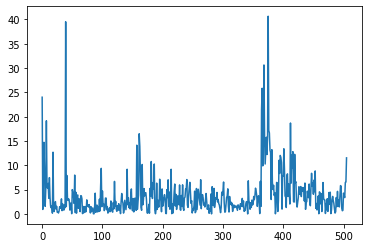

In [134]:
blr = BayesianLinearRegression(X_boston.shape[1], 0.3, 1)

predicted = []
for (x, y) in zip(X_boston, y_boston):
  predicted.append(blr.predict(x).mean())
  blr.learn(x, y)
plt.plot(range(y_boston.shape[0]), np.abs(y_boston - predicted))

Błąd utrzymuje się na stałym poziomie poza kilkoma przypadkami.

## Wygenerowanie szucznego zbioru z szumem Gaussowskim

In [69]:
space = np.linspace(-1, 1, 10)
new_set = [[space[i], -0.2 + 0.6 * space[i] + np.random.normal(0, 0.2, 10)[i]] for i in range(len(space))]

print(new_set)

[[-1.0, -0.8988460917994952], [-0.7777777777777778, -0.4470904729391728], [-0.5555555555555556, -0.2379548042277837], [-0.33333333333333337, -0.6252053635272928], [-0.11111111111111116, -0.5814935477492704], [0.11111111111111116, -0.18972031963578043], [0.33333333333333326, 0.1994589798195347], [0.5555555555555554, 0.2445800027367923], [0.7777777777777777, 0.38060692743541186], [1.0, 0.4707704386306809]]
